In [11]:
if(!require(markmyassignment)){
    install.packages("markmyassignment")
    library(markmyassignment)
}

In [12]:
assignment_path = paste("https://github.com/avehtari/BDA_course_Aalto/",
"blob/master/tests/assignment5.yml", sep="")
set_assignment(assignment_path)

Assignment set:
assignment5: Bayesian Data Analysis: Assignment 5
The assignment contain the following task:
- density_ratio




In [13]:
if(!require(aaltobda)){
    install.packages("aaltobda", repos = c("https://avehtari.github.io/BDA_course_Aalto/", getOption("repos")))
    library(aaltobda)
}

In [14]:
if(!require(latex2exp)){
    install.packages("latex2exp")
    library(latex2exp)
}

In [15]:
if(!require(posterior)){
    install.packages("posterior")
    library(posterior)
}

In [16]:
if(!require(ggplot2)){
    install.packages("ggplot2")
    library(ggplot2)
}

Loading required package: ggplot2



In [17]:
if(!require(bayesplot)){
    install.packages("bayesplot")
    library(bayesplot)
}

Loading required package: bayesplot

This is bayesplot version 1.13.0.9000

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘bayesplot’


The following object is masked from ‘package:posterior’:

    rhat




In [21]:
data("bioassay")
density_ratio <- function(alpha_propose, alpha_previous, beta_propose, beta_previous, x, y, n){
        prior_mean = c(0, 10)
    prior_sigma = cbind(c(4, 12), c(12, 100))
    ### error 
    exp( # just added exponential
        bioassaylp(alpha_propose, beta_propose, x, y, n)
        - bioassaylp(alpha_previous, beta_previous, x, y, n)
        + dmvnorm(c(alpha_propose, beta_propose), prior_mean, prior_sigma, TRUE)
        - dmvnorm(c(alpha_previous, beta_previous), prior_mean, prior_sigma, TRUE)
    )
    ### error 1
}

metropolis_bioassay <- function(alpha_initial, beta_initial, alpha_sigma, beta_sigma, no_draws, warmup_len, x, y, n, chain_number){
    data.frame(
        alpha=c(alpha_initial, alpha_initial+alpha_sigma, alpha_initial-alpha_sigma),
        beta=c(beta_initial, beta_initial+beta_sigma, beta_initial-beta_sigma)
    )
    alpha_previous = alpha_initial
    beta_previous = beta_initial
    alpha_rv = c()
    beta_rv = c()
    for(draw in 1:no_draws){
        alpha_propose = rnorm(1, alpha_previous, alpha_sigma)
        beta_propose = rnorm(1, beta_previous, beta_sigma)
        ### error 2
        #if(runif(1) > density_ratio(alpha_propose, alpha_previous, beta_propose, beta_previous, x, y, n))
        if(runif(1) < density_ratio(alpha_propose, alpha_previous, beta_propose, beta_previous, x, y, n))
        ### error 2
          {
            alpha_previous = alpha_propose
            beta_previous = beta_propose
          }
      ### error 3
        # alpha_rv = c(alpha_rv, alpha_propose)
        # beta_rv = c(beta_rv, beta_propose)
        alpha_rv = c(alpha_rv, alpha_previous) 
        beta_rv = c(beta_rv, beta_previous)
      ### error 3
    }
    data.frame(alpha=tail(alpha_rv,warmup_len), beta=tail(beta_rv, warmup_len), Chain=rep(chain_number, each=no_draws - warmup_len))
}

In [22]:
set.seed(4911)

df_chain1 = metropolis_bioassay(0, 0, 1, 1, 3000, 1000, bioassay$x, bioassay$y, bioassay$n, 1)
df_chain2 = metropolis_bioassay(1, 1, 1, 1, 3000, 1000, bioassay$x, bioassay$y, bioassay$n, 2)
df_chain3 = metropolis_bioassay(1, 5, 1, 1, 3000, 1000, bioassay$x, bioassay$y, bioassay$n, 3)
df_chain4 = metropolis_bioassay(5, 3, 1, 1, 3000, 1000, bioassay$x, bioassay$y, bioassay$n, 4)

df_combined_samples <- rbind(df_chain1, df_chain2, df_chain3, df_chain4)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


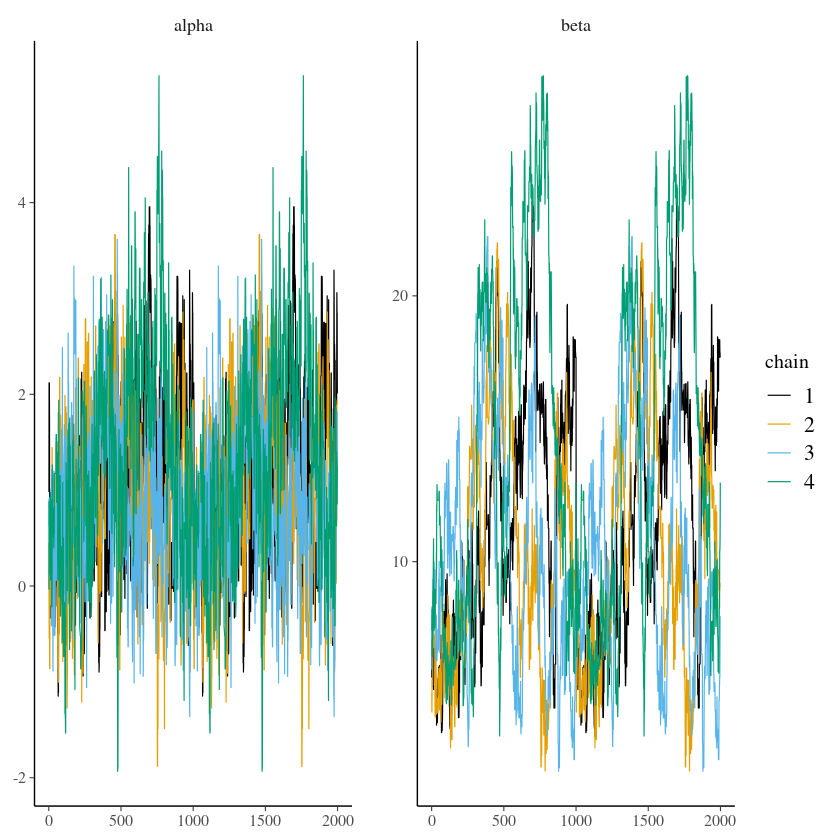

In [23]:
# Useful functions: mcmc_trace (from bayesplot)
mcmc_trace(df_combined_samples, pars=c("alpha", "beta")) + scale_colour_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))

In [26]:
# Load posterior package for Rhat and ESS
if(!require(posterior)){
    install.packages("posterior")
    library(posterior)
}

# Convert combined samples to a draws_df object
names(df_combined_samples)[names(df_combined_samples) == "Chain"] <- ".chain"
draws <- as_draws_df(df_combined_samples)

# Summarise draws: Rhat, ESS mean, ESS quantile (0.25)
summary_stats <- summarise_draws(
    draws,
    Rhat = rhat_basic,
    ESS  = ess_mean,
    ~ess_quantile(.x, probs = 0.25)
)

print(summary_stats)


# A tibble: 2 × 4
  variable  Rhat   ESS ess_q25
  <chr>    <dbl> <dbl>   <dbl>
1 alpha     1.02 107.     380.
2 beta      1.05  46.9    101.


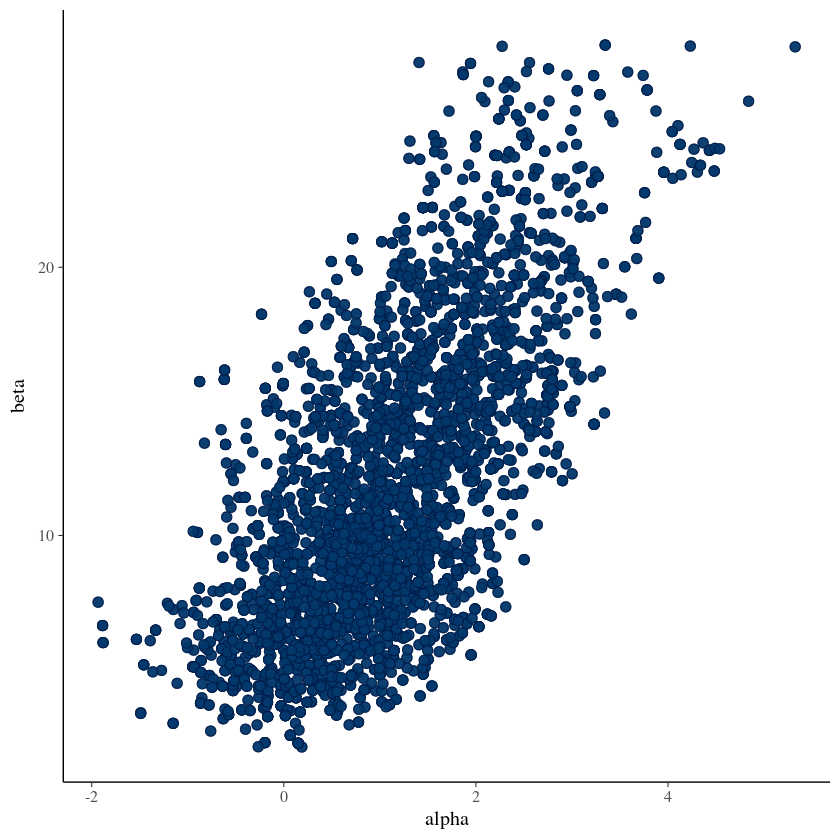

In [27]:
# Scatter plot to visualize posterior correlation
if(!require(bayesplot)){ install.packages("bayesplot"); library(bayesplot) }
mcmc_scatter(df_combined_samples, pars = c("alpha", "beta"))


In [29]:
# Ensure the necessary packages are loaded
# install.packages("aaltobda")
# install.packages("posterior")
library(aaltobda)
library(posterior)

# Load the dataset containing 4000 independent posterior draws
data("bioassay_posterior")

# Convert the dataset to a 'draws_df' object
# Since the draws are independent, they can be treated as a single chain.
draws_independent <- as_draws_df(bioassay_posterior)

# Calculate the effective sample size for the mean and 0.25 quantile
summary_independent <- summarise_draws(draws_independent, 
                                     ESS_mean = ess_mean, 
                                     ESS_q25 = ~ess_quantile(.x, probs = 0.25))

# Print the summary table
# For independent draws, ESS is always equal to the total number of draws.
print(summary_independent)
# A tibble: 2 × 3
#   variable ESS_mean ESS_q25
#   <chr>       <dbl>   <dbl>
# 1 alpha        4000    4000
# 2 beta         4000    4000

# A tibble: 2 × 3
  variable ESS_mean ess_q25
  <chr>       <dbl>   <dbl>
1 alpha       4110.   4202.
2 beta        4079.   4013.


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


# A tibble: 2 × 4
  variable  Rhat   ESS ess_q25
  <chr>    <dbl> <dbl>   <dbl>
1 alpha     1.02 107.     380.
2 beta      1.05  46.9    101.
# A tibble: 2 × 3
  variable ess_mean ess_q25
  <chr>       <dbl>   <dbl>
1 alpha       4110.   4202.
2 beta        4079.   4013.


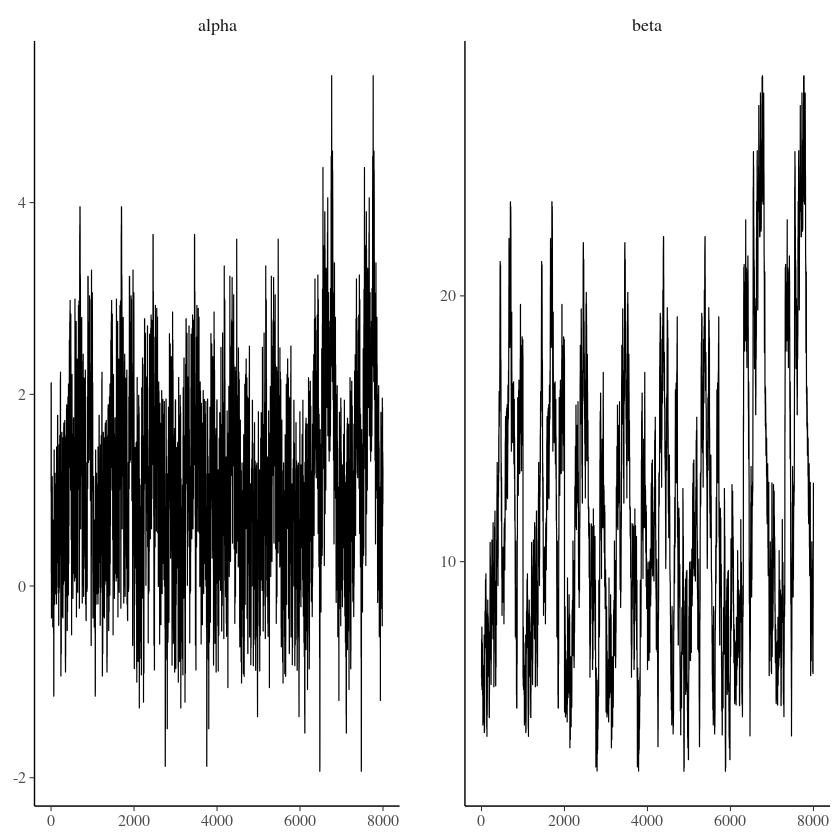

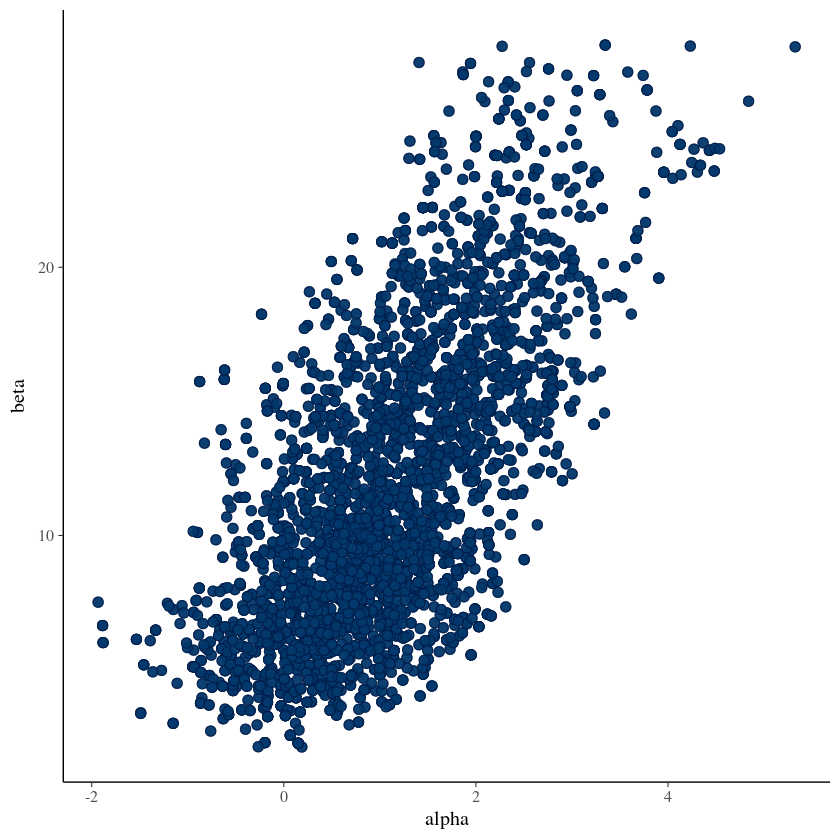

In [30]:
# Combine chains
df_combined_samples <- rbind(df_chain1, df_chain2, df_chain3, df_chain4)
names(df_combined_samples)[names(df_combined_samples) == "Chain"] <- ".chain"

# -----------------------------
# Trace plots
# -----------------------------
mcmc_trace(df_combined_samples, pars=c("alpha", "beta")) +
    scale_colour_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))

# -----------------------------
# Rhat and ESS for MCMC draws
# -----------------------------
draws <- as_draws_df(df_combined_samples)

summary_stats <- summarise_draws(
    draws,
    Rhat = rhat_basic,
    ESS  = ess_mean,
    ~ess_quantile(.x, probs = 0.25)
)
print(summary_stats)

# -----------------------------
# ESS for independent draws
# -----------------------------
data("bioassay_posterior")

posterior_draws <- as_draws_df(bioassay_posterior)

independent_ess <- summarise_draws(
    posterior_draws,
    ess_mean,
    ~ess_quantile(.x, probs = 0.25)
)
print(independent_ess)

# -----------------------------
# Optional: Scatter plot alpha vs beta
# -----------------------------
mcmc_scatter(df_combined_samples, pars=c("alpha", "beta"))